# Práctica Final: detección de mensajes troll en chat de Twitch en tiempo real

Durante este último año la plataforma de vídeo en streaming Twitch ha cogido mucha popularidad debido a la situación que hemos vivido debido al COVID-19. Por esto, mucha gente de todas las edades ha empezado a consumir esta plataforma de manera diaria.

Como consecuencia, no sólo han aumentado las personas que ven contenido en Twitch, sino también el número de los denominados *trolls*, gente que pone comentarios ofensivos en los chat de los streamers.

En esta práctica se desarrollará un sistema autónomo basado en IA y desplegado en GCP que detectará en tiempo real si los mensajes que se envían a un canal de Twitch son de un *troll* o no. La práctica constará de tres partes principales que serán evaluadas en la corrección:
1. Entrenamiento e inferencia en Batch de un modelo usando Dataflow y AI Platform. **(3.5 puntos)**.
2. Despliegue e inferencia online en microservicio con el modelo. **(3.5 puntos)**.
3. Inferencia en streaming de un canal de Twitch con el microservicio anterior. **(3 puntos)**.

# Configuración de nuestro proyecto en GCP


In [ ]:
#Cargo el drive que usaré para guardar los ficheros que vaya haciendo
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Todos los directorios con los ficheros generados durante la práctica están en el siguiente repositiorio GIT
https://gitlab.com/Lorenamh/practica-despliegues.git

## Identificación y creación del bucket

In [ ]:
PROJECT_ID = "twitch-troll-practice" #@param {type:"string"}
! gcloud config set project $PROJECT_ID

Updated property [core/project].


In [ ]:
import sys

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()

# If you are running this notebook locally, replace the string below with the
# path to your service account key and run this cell to authenticate your GCP
# account.
else:
  %env GOOGLE_APPLICATION_CREDENTIALS ''


In [ ]:
BUCKET_NAME = "twitch-troll-practice-21022022" #@param {type:"string"}
REGION = "europe-west1" #@param {type:"string"}

In [ ]:
! gsutil ls -al gs://$BUCKET_NAME

   2756023  2022-02-24T08:09:59Z  gs://twitch-troll-practice-21022022/data.json#1645690199893587  metageneration=1
TOTAL: 1 objects, 2756023 bytes (2.63 MiB)


# Entrenamiento e inferencia en Batch

Para esta primera parte se va a utilizar [Tweets Dataset for Detection of Cyber-Trolls](https://www.kaggle.com/dataturks/dataset-for-detection-of-cybertrolls). El objetivo es desarrollar un clasificador binario para detectar si el mensaje recibido es troll (1) o no (0). **Las métricas obtenidas del entrenamiento y la inferencia no se tendrán en cuenta para la evaluación de la práctica, la importancia está en la arquitectura de la solución**.

A continuación os dejo un diagrama con la arquitectura que se va a desarrollar:

![batch_diagram](https://drive.google.com/uc?export=view&id=1h1BkIunyKSkJYFRbXKNWpHOZ_rDUyGAT)

A continuación, se van a subir los datos de entrenamiento al bucket del proyecto que se haya creado. **Importante:** crea el bucket en una única región para evitar problemas más adelante.

In [ ]:
# Upload data to your bucket
! wget https://storage.googleapis.com/twitch-practice-keepcoding/data.json -O - | gsutil cp - gs://$BUCKET_NAME/data.json

--2022-02-25 12:18:35--  https://storage.googleapis.com/twitch-practice-keepcoding/data.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.128, 172.217.0.48, 172.217.1.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2756023 (2.6M) [application/json]
Saving to: ‘STDOUT’

-                     0%[                    ]       0  --.-KB/s               Copying from <STDIN>...
-                   100%[===================>]   2.63M  1.48MB/s    in 1.8s    

2022-02-25 12:18:37 (1.48 MB/s) - written to stdout [2756023/2756023]

/ [1 files][    0.0 B/    0.0 B]                                                
Operation completed over 1 objects.                                              


Ahora se crea el directorio dónde vas a desarrollar esta primera parte de la práctica.

In [ ]:
%mkdir /content/batch


Se establece el directorio de trabajo que hemos creado.

In [ ]:
import os

# Set the working directory to the sample code directory
%cd /content/batch

WORK_DIR = os.getcwd()

/content/batch


Ahora se descargarán los datos en el workspace de Colab para trabajar en local.

In [ ]:
! wget https://storage.googleapis.com/twitch-practice-keepcoding/data.json

--2022-02-25 10:48:28--  https://storage.googleapis.com/twitch-practice-keepcoding/data.json
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.115.128, 172.253.122.128, 142.250.81.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.115.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2756023 (2.6M) [application/json]
Saving to: ‘data.json’

data.json           100%[===================>]   2.63M  --.-KB/s    in 0.01s   

2022-02-25 10:48:28 (190 MB/s) - ‘data.json’ saved [2756023/2756023]



Se establecen las dependencias que se usarán en la práctica. Se pueden añadir y quitar las dependencias que no se usen o viceversa.

In [ ]:
%%writefile requirements.txt

apache-beam[gcp]==2.24.0
tensorflow ==2.8.0
gensim==3.6.0
fsspec==0.8.4
gcsfs==0.7.1
numpy==1.20.0

Overwriting requirements.txt


Instalamos las dependencias. **No olvidarse de reiniciar el entorno al instalar y establecer las variables y credenciales de GCP al arrancar.**

In [ ]:
! pip install -r requirements.txt

##**Entreglable (0.5 puntos)**

Desarrollar un pipeline de preprocesamiento utilizando Apache Beam para generar datos de train, eval y test para los datos proporcionados anteriormente. Requisitos:

- Proporcionar dos modos de ejecución: `train` y `test`
- Soportar ejecuciones en local con `DirectRunner` y ejecuciones en Dataflow usando `DataFlowRunner`.

In [ ]:
%%writefile preprocess.py

# Rellena con tu solución

from __future__ import absolute_import

import argparse
import logging
import re
import os
import csv
import json
import random

from past.builtins import unicode

import apache_beam as beam
from apache_beam.io import ReadFromText
from apache_beam.io import WriteToText
from apache_beam.coders.coders import Coder
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.options.pipeline_options import SetupOptions, DirectOptions

import nltk



nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer


nltk.download("stopwords")

# CLEANING
STOP_WORDS = stopwords.words("english")
STEMMER = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"


class ExtractColumnsDoFn(beam.DoFn):
    def process(self, element):
        # space removal
        
        data = json.loads(element)        
        content = data.get('content')
        annotation = data.get('annotation')
        label = annotation.get('label')[0]
        yield [content ,  label ]

 #       element_split = list(csv.reader(element, delimiter=","))
 #       element_split = [x for x in element_split if x != ["", ""]]
        # text, sentiment
 #       yield element_split[5][-1], element_split[0][-1]


class PreprocessColumnsTrainFn(beam.DoFn):
    def process_sentiment(self, label):
      
        annotation = int(label)
        if annotation == 1:
            return "TROLL"

        else:
            return "OK"

    def process_text(self, text):
        # Remove link,user and special characters
        stem = False
        text = re.sub(TEXT_CLEANING_RE, " ", str(text).lower()).strip()
        tokens = []
        for token in text.split():
            if token not in STOP_WORDS:
                if stem:
                     #tokens.append(lemmatizer.lemmatize(token))
                    tokens.append(STEMMER.stem(token))
                else:
                    tokens.append(token)
        return " ".join(tokens)

    def process(self, element):
        processed_text = self.process_text(element[0])
        processed_sentiment = self.process_sentiment(element[1])
        yield f"{processed_text}, {processed_sentiment}"


class CustomCoder(Coder):
    """A custom coder used for reading and writing strings"""

    def __init__(self, encoding: str):
        # latin-1
        # iso-8859-1
        self.enconding = encoding

    def encode(self, value):
        return value.encode(self.enconding)

    def decode(self, value):
        return value.decode(self.enconding)

    def is_deterministic(self):
        return True


def run(argv=None, save_main_session=True):

    """Main entry point; defines and runs the wordcount pipeline."""

    parser = argparse.ArgumentParser()

    parser.add_argument(
        "--work-dir", dest="work_dir", required=True, help="Working directory",
    )

    parser.add_argument(
        "--input", dest="input", required=True, help="Input dataset in work dir",
    )
    parser.add_argument(
        "--output",
        dest="output",
        required=True,
        help="Output path to store transformed data in work dir",
    )
    parser.add_argument(
        "--mode",
        dest="mode",
        required=True,
        choices=["train", "test"],
        help="Type of output to store transformed data",
    )

    known_args, pipeline_args = parser.parse_known_args(argv)

    # We use the save_main_session option because one or more DoFn's in this
    # workflow rely on global context (e.g., a module imported at module level).
    pipeline_options = PipelineOptions(pipeline_args)
    pipeline_options.view_as(SetupOptions).save_main_session = save_main_session
    pipeline_options.view_as(DirectOptions).direct_num_workers = 0

    # The pipeline will be run on exiting the with block.
    with beam.Pipeline(options=pipeline_options) as p:

        # Read the text file[pattern] into a PCollection.
        raw_data = p | "ReadTwitterData" >> ReadFromText(
            known_args.input, coder=CustomCoder("latin-1")
        )

        if known_args.mode == "train":

            transformed_data = (
                raw_data
                | "ExtractColumns" >> beam.ParDo(ExtractColumnsDoFn())
                | "Preprocess" >> beam.ParDo(PreprocessColumnsTrainFn())
            )

            eval_percent = 20
            assert 0 < eval_percent < 100, "eval_percent must in the range (0-100)"
            train_dataset, eval_dataset = (
                transformed_data
                | "Split dataset"
                >> beam.Partition(
                    lambda elem, _: int(random.uniform(0, 100) < eval_percent), 2
                )
            )

            train_dataset | "TrainWriteToCSV" >> WriteToText(
                os.path.join(known_args.output, "train", "part")
            )
            eval_dataset | "EvalWriteToCSV" >> WriteToText(
                os.path.join(known_args.output, "eval", "part")
            )

        else:
            transformed_data = (
                raw_data
                | "ExtractColumns" >> beam.ParDo(ExtractColumnsDoFn())
                | "Preprocess" >> beam.Map(lambda x: f'"{x[0]}"')
            )

            transformed_data | "TestWriteToCSV" >> WriteToText(
                os.path.join(known_args.output, "test", "part")
            )


if __name__ == "__main__":
    logging.getLogger().setLevel(logging.INFO)
    run()


Writing preprocess.py


Se proporciona un fichero `setup.py` necesario para ejecutar en DataFlow. Modificar la variable `REQUIRED_PACKAGES` con las dependencias que se hayan usado en el `requirements.txt`

In [ ]:
%%writefile setup.py

import setuptools

REQUIRED_PACKAGES = [
  "apache-beam[gcp]==2.24.0",
  "tensorflow==2.8.0",
  "gensim==3.6.0",
  "fsspec==0.8.4",
  "gcsfs==0.7.1",
  "numpy==1.20.0",
  "keras==2.8.0",
]

setuptools.setup(
    name="twitchstreaming",
    version="0.0.1",
    install_requires=REQUIRED_PACKAGES,
    packages=setuptools.find_packages(),
    include_package_data=True,
    description="Troll detection",
)


Overwriting setup.py


### Validación preprocess train en local (0.25 puntos)

Con el comando mostrado a continuación se valida la correcta generación de los datos de entrenamiento y validación en local.

In [ ]:
! python3 preprocess.py \
  --work-dir $WORK_DIR \
  --runner DirectRunner \
  --input $WORK_DIR/data.json \
  --output $WORK_DIR/transformed_data \
  --mode train

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function annotate_downstream_side_inputs at 0x7ff981834a70> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function fix_side_input_pcoll_coders at 0x7ff981834b90> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function lift_combiners at 0x7ff981834c20> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function expand_sdf at 0x7ff981834cb0> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function expand_gbk at 0x7ff981834d40> ===============

### Validación preprocess test en local (0.25 puntos)

Con el comando mostrado a continuación se valida la correcta generación de los datos de test en local.

In [ ]:
! python3 preprocess.py \
  --work-dir $WORK_DIR \
  --runner DirectRunner \
  --input $WORK_DIR/data.json \
  --output $WORK_DIR/transformed_data \
  --mode test

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function annotate_downstream_side_inputs at 0x7f4e0f075d40> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function fix_side_input_pcoll_coders at 0x7f4e0f075e60> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function lift_combiners at 0x7f4e0f075ef0> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function expand_sdf at 0x7f4e0f075f80> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function expand_gbk at 0x7f4e0f078050> ===============

## Entregable 2 (1.25 puntos)

Desarrollar una tarea de entrenamiento para los datos preprocesados. Requisitos:

- Soportar ejecuciones en local usando el SDK de AI-Platform y ejecuciones en GCP con el mismo código.

Se crea el directorio donde se dejará este entregable.

In [ ]:
%mkdir /content/batch/trainer


In [ ]:
%%writefile trainer/__init__.py

version = "0.1.0"

Writing trainer/__init__.py


In [ ]:
%%writefile trainer/task.py

from __future__ import absolute_import

import argparse
import multiprocessing as mp
import logging
import tempfile
import os

import pickle
import gensim
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Embedding,
    LSTM,GRU,Bidirectional,Conv1D
)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import LabelEncoder


# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
# 32
W2V_EPOCH = 5
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300

# SENTIMENT
TROLL = "TROLL"
OK= "OK"

SENTIMENT_THRESHOLDS = (0.5)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"


def generate_word2vec(train_df):
    documents = [_text.split() for _text in train_df.text.values]
    w2v_model = gensim.models.word2vec.Word2Vec(
        size=W2V_SIZE,
        window=W2V_WINDOW,
        min_count=W2V_MIN_COUNT,
        workers=mp.cpu_count(),
    )
    w2v_model.build_vocab(documents)

    words = w2v_model.wv.vocab.keys()
    vocab_size = len(words)
    logging.info(f"Vocab size: {vocab_size}")
    w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

    return w2v_model


def generate_tokenizer(train_df):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_df.text)
    vocab_size = len(tokenizer.word_index) + 1
    logging.info(f"Total words: {vocab_size}")
    print(vocab_size)
    return tokenizer, vocab_size


def generate_label_encoder(train_df):
    encoder = LabelEncoder()
    encoder.fit(train_df.sentiment.tolist())
    return encoder


def generate_embedding(word2vec_model, vocab_size, tokenizer):
    embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
    for word, i in tokenizer.word_index.items():
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]
    return Embedding(
        vocab_size,
        W2V_SIZE,
        weights=[embedding_matrix],
        input_length=SEQUENCE_LENGTH,
        trainable=False,
    )


def train_and_evaluate(
    work_dir, train_df, eval_df, batch_size=64, epochs=8, steps=1000
):

    """
    Trains and evaluates the estimator given.
    The input functions are generated by the preprocessing function.
    """

    #model_dir = os.path.join(work_dir, "/model")
    model_dir = work_dir
    if tf.io.gfile.exists(model_dir):
        tf.io.gfile.rmtree(model_dir)
    tf.io.gfile.mkdir(model_dir)

    # Specify where to store our model
    run_config = tf.estimator.RunConfig()
    run_config = run_config.replace(model_dir=model_dir)

    # This will give us a more granular visualization of the training
    run_config = run_config.replace(save_summary_steps=10)

    # Create Word2vec of training data
    logging.info("---- Generating word2vec model ----")
    word2vec_model = generate_word2vec(train_df)

    # Tokenize training data
    logging.info("---- Generating tokenizer ----")
    tokenizer, vocab_size = generate_tokenizer(train_df)

    logging.info("---- Tokenizing train data ----")
    x_train = pad_sequences(
        tokenizer.texts_to_sequences(train_df.text), maxlen=SEQUENCE_LENGTH
    )
    logging.info("---- Tokenizing eval data ----")
    x_eval = pad_sequences(
        tokenizer.texts_to_sequences(eval_df.text), maxlen=SEQUENCE_LENGTH
    )

    # Label Encoder
    logging.info("---- Generating label encoder ----")
    label_encoder = generate_label_encoder(train_df)

    logging.info("---- Encoding train target ----")
    y_train = label_encoder.transform(train_df.sentiment.tolist())
    logging.info("---- Encoding eval target ----")
    y_eval = label_encoder.transform(eval_df.sentiment.tolist())

    y_train = y_train.reshape(-1, 1)
    y_eval = y_eval.reshape(-1, 1)

    # Create Embedding Layer
    logging.info("---- Generating embedding layer ----")
    embedding_layer = generate_embedding(word2vec_model, vocab_size, tokenizer)

    logging.info("---- Generating Sequential model ----")
    #model = Sequential()
    #model.add(embedding_layer)
    #model.add(Bidirectional(GRU(100, return_sequences=True)))
    #model.add(Bidirectional(GRU(100))),
    #model.add(Dropout(0.2)),
    #model.add(Dense(100, 'relu')),
    #model.add(Dense(1, 'sigmoid'))
    model = Sequential()
    model.add(Embedding(vocab_size, 255, input_length=300),)
    model.add(Conv1D(32, 4)),
    #model.add(embedding_layer) 
    model.add(Bidirectional(GRU(100,return_sequences=True)))
    model.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))   
    model.add(Dense(100, 'relu'))
    model.add(Dense(1, activation="sigmoid"))

    model.summary()

    logging.info("---- Adding loss function to model ----")
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    logging.info("---- Adding callbacks to model ----")
    callbacks = [
        ReduceLROnPlateau(monitor="val_loss", patience=5, cooldown=0),
        EarlyStopping(monitor="val_accuracy", min_delta=1e-4, patience=5),
    ]

    logging.info("---- Training model ----")
    logging.info(str(len(x_train)))
    model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        steps_per_epoch= len(x_train)/batch_size,
        #steps_per_epoch=steps,
        epochs=epochs,
        validation_split=0.1,
        shuffle=True,
        verbose=1,
        callbacks=callbacks,
    )

    logging.info("---- Evaluating model ----")
    score = model.evaluate(x_eval, y_eval, batch_size=batch_size)
    logging.info(f"ACCURACY: {score[1]}")
    logging.info(f"LOSS: {score[0]}")

    logging.info("---- Saving models ----")
    pickle.dump(
        tokenizer,
        tf.io.gfile.GFile(os.path.join(model_dir, TOKENIZER_MODEL), mode="wb"),
        protocol=0,
    )

    
    with tempfile.NamedTemporaryFile(suffix=".h5") as local_file:
        with tf.io.gfile.GFile(
            os.path.join(model_dir, KERAS_MODEL), mode="wb"
        ) as gcs_file:
            model.save(local_file.name)
            gcs_file.write(local_file.read())

    #word2vec_model.save(os.path.join(model_dir, WORD2VEC_MODEL))

    #pickle.dump(
     #    label_encoder, open(os.path.join(model_dir, ENCODER_MODEL), "wb"), protocol=0
     #)


if __name__ == "__main__":

    """Main function called by AI Platform."""

    logging.getLogger().setLevel(logging.INFO)

    parser = argparse.ArgumentParser(
        formatter_class=argparse.ArgumentDefaultsHelpFormatter
    )

    parser.add_argument(
        "--job-dir",
        help="Directory for staging trainer files. "
        "This can be a Google Cloud Storage path.",
    )

    parser.add_argument(
        "--work-dir",
        required=True,
        help="Directory for staging and working files. "
        "This can be a Google Cloud Storage path.",
    )

    parser.add_argument(
        "--batch-size",
        type=int,
        default=64,
        help="Batch size for training and evaluation.",
    )

    parser.add_argument(
        "--epochs", type=int, default=8, help="Number of epochs to train the model",
    )

    parser.add_argument(
        "--steps",
        type=int,
        default=1000,
        help="Number of steps per epoch to train the model",
    )

    args = parser.parse_args()

    train_data_files = tf.io.gfile.glob(
        os.path.join(args.work_dir, "transformed_data/train/part-*")
    )
    eval_data_files = tf.io.gfile.glob(
        os.path.join(args.work_dir, "transformed_data/eval/part-*")
    )


    train_df = pd.concat(
        [
            pd.read_csv(
                f,
                names=["text", "sentiment"],
                dtype={"text": "string", "sentiment": "string"},sep=","
            )
            for f in train_data_files
        ]
    ).dropna()

    eval_df = pd.concat(
        [
            pd.read_csv(
                f,
                names=["text", "sentiment"],
                dtype={"text": "string", "sentiment": "string"},sep=","
            )
            for f in eval_data_files
        ]
    ).dropna()

    train_and_evaluate(
        args.work_dir,
        train_df=train_df,
        eval_df=eval_df,
        batch_size=args.batch_size,
        epochs=args.epochs,
        steps=args.steps,
    )

Overwriting trainer/task.py


### Validación Train en local

Con el comando mostrado a continuación se valida el correcto entrenamiento del modelo usando los datos preprocesados del apartado anterior.

In [ ]:
%mkdir /content/batch/model

In [ ]:
# Explicitly tell `gcloud ai-platform local train` to use Python 3 
! gcloud config set ml_engine/local_python $(which python3)

# This is similar to `python -m trainer.task --job-dir local-training-output`
# but it better replicates the AI Platform environment, especially for
# distributed training (not applicable here).
! gcloud ai-platform local train \
  --package-path trainer \
  --module-name trainer.task \
  -- \
  --work-dir $WORK_DIR \
  --epochs 3

Updated property [ml_engine/local_python].
INFO:tensorflow:TF_CONFIG environment variable: {'job': {'job_name': 'trainer.task', 'args': ['--work-dir', '/content/batch', '--epochs', '3']}, 'task': {}, 'cluster': {}, 'environment': 'cloud'}
INFO:root:---- Generating word2vec model ----
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 68409 words, keeping 11748 word types
INFO:gensim.models.word2vec:collected 14705 word types from a corpus of 114075 raw words and 15857 sentences
INFO:gensim.models.word2vec:Loading a fresh vocabulary
INFO:gensim.models.word2vec:effective_min_count=10 retains 1587 unique words (10% of original 14705, drops 13118)
INFO:gensim.models.word2vec:effective_min_count=10 leaves 84375 word corpus (73% of original 114075, drops 29700)
INFO:gensim.models.word2vec:deleting the raw counts dicti

In [ ]:
#No se he podido guardar los modelos en la carpeta model, al final he tenido que poner que se guarden en la raíz.
#Muevo los ficheros de forma manual a la carpeta
%mv /content/batch/model.h5 /content/batch/model
%mv /content/batch/tokenizer.pkl /content/batch/model

mv: cannot stat '/content/batch/model.h5': No such file or directory


## Entregable 3 (0.5 puntos)

Desarrollar un pipeline de inferencia utilizando Apache Beam para generar predicciones usando los modelos generados en el apartado anterior así como los de test generados en el primer entregable.


In [ ]:
%%writefile predict.py

# Rellena con tu solución

from __future__ import absolute_import
from __future__ import print_function

import argparse
import tempfile
import json
import os
import sys
import time

import apache_beam as beam
from apache_beam.io import ReadFromText
from apache_beam.io import WriteToText
from apache_beam.options.pipeline_options import GoogleCloudOptions
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.options.pipeline_options import SetupOptions
from apache_beam.coders.coders import Coder

import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

# KERAS
SEQUENCE_LENGTH = 300

# SENTIMENT
# SENTIMENT
TROLL = "TROLL"
OK= "OK"

SENTIMENT_THRESHOLDS = (0.5)

# EXPORT
KERAS_MODEL = "model.h5"
TOKENIZER_MODEL = "tokenizer.pkl"



class Predict(beam.DoFn):
    def __init__(
        self, model_dir,
    ):
        self.model_dir =model_dir
        self.model = None
        self.tokenizer = None

    def setup(self):
        keras_model_path = os.path.join(self.model_dir, KERAS_MODEL)
        with tempfile.NamedTemporaryFile(suffix=".h5") as local_file:
            with tf.io.gfile.GFile(keras_model_path, mode="rb") as gcs_file:
                local_file.write(gcs_file.read())
                self.model = tf.keras.models.load_model(local_file.name)

        tokenizer_path = os.path.join(self.model_dir, TOKENIZER_MODEL)
        self.tokenizer = pickle.load(tf.io.gfile.GFile(tokenizer_path, mode="rb"))




    def decode_sentiment(self, score, include_neutral=True):
        if include_neutral:
            label = OK
            if score >  SENTIMENT_THRESHOLDS:
                label = TROLL


            return label
        else:
            return OK if score < 0.5 else TROLL

    def process(self, element):
        start_at = time.time()
        # Tokenize text
        x_test = pad_sequences(
            self.tokenizer.texts_to_sequences([element]), maxlen=SEQUENCE_LENGTH
        )
        # Predict
        score = self.model.predict([x_test])[0]
        # Decode sentiment
        label = self.decode_sentiment(score)

        yield {
            "text": element,
            "label": label,
            "score": float(score),
            "elapsed_time": time.time() - start_at,
        }


class CustomCoder(Coder):
    """A custom coder used for reading and writing strings"""

    def __init__(self, encoding: str):
        # latin-1
        # iso-8859-1
        self.enconding = encoding

    def encode(self, value):
        return value.encode(self.enconding)

    def decode(self, value):
        return value.decode(self.enconding)

    def is_deterministic(self):
        return True


def run(model_dir, source, sink, beam_options=None):
    with beam.Pipeline(options=beam_options) as p:
        _ = (
            p
            | "Read data" >> source
            # | "Preprocess" >> beam.ParDo(PreprocessTextFn(model_dir, "ID"))
            | "Predict" >> beam.ParDo(Predict(model_dir))
            | "Format as JSON" >> beam.Map(json.dumps)
            | "Write predictions" >> sink
        )


if __name__ == "__main__":
    """Main function"""
   # parser = argparse.ArgumentParser(
    #    formatter_class=argparse.ArgumentDefaultsHelpFormatter
    #)

   # parser.add_argument(
    #    "--work-dir",
     #   dest="work_dir",
      #  required=True,
       # help="Directory for temporary files and preprocessed datasets to. "
        #"This can be a Google Cloud Storage path.",
   # )

    parser = argparse.ArgumentParser()

    parser.add_argument(
        "--work-dir", dest="work_dir", required=True, help="Working directory",
    )
    parser.add_argument(
        "--model-dir",
        dest="model_dir",
        required=True,
        help="Path to the exported TensorFlow model. "
        "This can be a Google Cloud Storage path.",
    )

    verbs = parser.add_subparsers(dest="verb")
    batch_verb = verbs.add_parser("batch", help="Batch prediction")
    batch_verb.add_argument(
        "--inputs-dir",
        dest="inputs_dir",
        required=True,
        help="Input directory where CSV data files are read from. "
        "This can be a Google Cloud Storage path.",
    )
    batch_verb.add_argument(
        "--outputs-dir",
        dest="outputs_dir",
        required=True,
        help="Directory to store prediction results. "
        "This can be a Google Cloud Storage path.",
    )

    args, pipeline_args = parser.parse_known_args()
    print(args)
    beam_options = PipelineOptions(pipeline_args)
    beam_options.view_as(SetupOptions).save_main_session = True
    # beam_options.view_as(DirectOptions).direct_num_workers = 0

    project = beam_options.view_as(GoogleCloudOptions).project

    if args.verb == "batch":
        results_prefix = os.path.join(args.outputs_dir, "part")

        source = ReadFromText(args.inputs_dir, coder=CustomCoder("latin-1"))
        sink = WriteToText(results_prefix)

    else:
        parser.print_usage()
        sys.exit(1)

    run(args.model_dir, source, sink, beam_options)

Overwriting predict.py


Generamos un timestamp para la ejecución de las predicciones

In [ ]:
from datetime import datetime

# current date and time
TIMESTAMP = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

### Validación Predict en local

Con el comando mostrado a continuación se valida la correcta inferencia usando los modelos anteriores y los datos de test generados anteriormente.

In [ ]:
WORK_DIR = os.getcwd()
WORK_DIR

'/content/batch'

In [ ]:
! python3 predict.py \
  --work-dir $WORK_DIR \
  --model-dir  $WORK_DIR/model \
  batch \
  --inputs-dir $WORK_DIR/transformed_data/test/part* \
  --outputs-dir $WORK_DIR/predictions/$TIMESTAMP

Namespace(inputs_dir='/content/batch/transformed_data/test/part-00000-of-00002', model_dir='/content/batch/model', outputs_dir='/content/batch/predictions/2022-02-25_11-33-40', verb='batch', work_dir='/content/batch')
2022-02-25 11:33:54.326093: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_conver

##Entregable 4 (1.25 puntos)

En este entregable se validará el funcionamiento del código en un proyecto de GCP sobre DataFlow y AI Platform

Establecemos el bucket y region de GCP sobre el que trabajaremos:

In [ ]:
GCP_WORK_DIR = 'gs://' + BUCKET_NAME 
GCP_REGION = 'europe-west1'

In [ ]:
! ls

data.json  predict.py	  requirements.txt  trainer
model	   preprocess.py  setup.py	    transformed_data


### Validación preprocess train en Dataflow (0.25 puntos)

Con el comando mostrado a continuación se valida la correcta generación de los datos de entrenamiento y validación en GCP con el servicio DataFlow.

In [ ]:
! python3 preprocess.py \
  --project $PROJECT_ID \
  --region $GCP_REGION \
  --runner DataflowRunner \
  --temp_location $GCP_WORK_DIR/beam-temp \
  --setup_file ./setup.py \
  --work-dir $GCP_WORK_DIR \
  --input $GCP_WORK_DIR/data.json \
  --output $GCP_WORK_DIR/transformed_data \
  --mode train

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
INFO:apache_beam.internal.gcp.auth:Setting socket default timeout to 60 seconds.
INFO:apache_beam.internal.gcp.auth:socket default timeout is 60.0 seconds.
INFO:oauth2client.transport:Attempting refresh to obtain initial access_token
INFO:oauth2client.client:Refreshing access_token
INFO:apache_beam.runners.portability.stager:Executing command: ['/usr/bin/python3', 'setup.py', 'sdist', '--dist-dir', '/tmp/tmpkckw3e4d']



INFO:apache_beam.runners.portability.stager:Downloading source distribution of the SDK from PyPi
INFO:apache_beam.runners.portability.stager:Executing command: ['/usr/bin/python3', '-m', 'pip', 'download', '--dest', '/tmp/tmpkckw3e4d', 'apache-beam==2.24.0', '--no-deps', '--no-binary', ':all:']
INFO:apache_beam.runners.portability.stager:S

### Validación preprocess test en Dataflow (0.25 puntos)

Con el comando mostrado a continuación se valida la correcta generación de los datos de test en GCP con el servicio DataFlow.

In [ ]:
! python3 preprocess.py \
  --project $PROJECT_ID \
  --region $GCP_REGION \
  --runner DataflowRunner \
  --temp_location $GCP_WORK_DIR/beam-temp \
  --setup_file ./setup.py \
  --work-dir $GCP_WORK_DIR \
  --input $GCP_WORK_DIR/data.json \
  --output $GCP_WORK_DIR/transformed_data \
  --mode test

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
INFO:apache_beam.internal.gcp.auth:Setting socket default timeout to 60 seconds.
INFO:apache_beam.internal.gcp.auth:socket default timeout is 60.0 seconds.
INFO:oauth2client.transport:Attempting refresh to obtain initial access_token
INFO:oauth2client.client:Refreshing access_token
INFO:apache_beam.runners.portability.stager:Executing command: ['/usr/bin/python3', 'setup.py', 'sdist', '--dist-dir', '/tmp/tmp08m5ol2m']



INFO:apache_beam.runners.portability.stager:Downloading source distribution of the SDK from PyPi
INFO:apache_beam.runners.portability.stager:Executing command: ['/usr/bin/python3', '-m', 'pip', 'download', '--dest', '/tmp/tmp08m5ol2m', 'apache-beam==2.24.0', '--no-deps', '--no-binary', ':all:']
INFO:apache_beam.runners.portability.stager:S

### Validación Train en AI Platform (0.5 puntos)

Con el comando mostrado a continuación se valida el correcto entrenamiento del modelo usando los datos de las ejecuciones anteriores en GCP con los datos obtenidos almacenados en Google Cloud Storage.

Generamos un nombre para el job de entrenamiento y donde se almacenarán los metadatos.

In [ ]:
JOB = "troll_detection_batch_$(date +%Y%m%d_%H%M%S)"
JOB_DIR = GCP_WORK_DIR + "/trainer"

In [ ]:
! gcloud ai-platform jobs submit training $JOB \
  --module-name trainer.task \
  --package-path trainer \
  --scale-tier basic_gpu \
  --python-version 3.7 \
  --runtime-version 2.8 \
  --region $GCP_REGION \
  --job-dir $JOB_DIR \
  --stream-logs \
  -- \
  --work-dir $GCP_WORK_DIR \
  --epochs 3

Job [troll_detection_batch_20220225_115535] submitted successfully.
Received keyboard interrupt.

Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe troll_detection_batch_20220225_115535

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs troll_detection_batch_20220225_115535
jobId: troll_detection_batch_20220225_115535
state: PREPARING


In [ ]:
#Mismo problema, creo en el bucket de forma manual la carpeta model y meto los modelos, ya que solo consigo que lo guarde en la raíz.

### Validación predict en Dataflow (0.25 puntos)

Con el comando mostrado a continuación se valida la predicción correcta de los datos de test usando los modelos generados en el comando anterior.

Generamos un timestamp para el almacenamiento de las inferencias en Google Cloud Storage.

In [ ]:
from datetime import datetime

# current date and time
TIMESTAMP = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

In [ ]:

! python3 predict.py \
  --work-dir $GCP_WORK_DIR \
  --model-dir $GCP_WORK_DIR/model \
  batch \
  --project $PROJECT_ID \
  --region $GCP_REGION \
  --runner DataflowRunner \
  --temp_location $GCP_WORK_DIR/beam-temp \
  --setup_file ./setup.py \
  --inputs-dir $GCP_WORK_DIR/transformed_data/test/part* \
  --outputs-dir $GCP_WORK_DIR/predictions/$TIMESTAMP

Namespace(inputs_dir='gs://twitch-troll-practice-21022022/transformed_data/test/part*', model_dir='gs://twitch-troll-practice-21022022/model', outputs_dir='gs://twitch-troll-practice-21022022/predictions/2022-02-25_13-23-12', verb='batch', work_dir='gs://twitch-troll-practice-21022022')



Traceback (most recent call last):
  File "predict.py", line 185, in <module>
    run(args.model_dir, source, sink, beam_options)
  File "predict.py", line 119, in run
    | "Write predictions" >> sink
  File "/usr/local/lib/python3.7/dist-packages/apache_beam/pipeline.py", line 556, in __exit__
    self.result.wait_until_finish()
  File "/usr/local/lib/python3.7/dist-packages/apache_beam/runners/dataflow/dataflow_runner.py", line 1619, in wait_until_finish
    time.sleep(5.0)
KeyboardInterrupt
^C


In [ ]:
%cd /content/batch

/content/batch


# Inferencia online

En esta segunda parte de la práctica se realizará un microservicio de inferencia online usando los modelos generados en la primera parte. Para esta parte de la práctica el código de vuestro microservicio deberá estar subido en un repositorio. En la variable de debajo deberéis dejar la URL a vuestro repositorrio pues será el contenido con el que serás evaluado. 

**Importante:** asegúrate de crear el repositorio de manera pública para poder clonarlo.

A continuación os dejo un diagrama con la arquitectura que se va a desarrollar:

![online_diagram](https://drive.google.com/uc?export=view&id=1zR7Cwp0Vq1QeTxwLoJ8YJNRM9G5KVh2S)

In [ ]:
REPOSITORIO = "https://gitkc.cloud/despliegue-de-algoritmos-viii/troll-detection-online-service.git"

Creamos el directorio donde trabajaremos.

In [ ]:
%mkdir /content/online
%cd /content/online

/content/online


In [ ]:
# Clone the repository
! git clone $REPOSITORIO

# Set the working directory to the sample code directory
%cd ./troll-detection-online-service

# Change to develop
! git checkout develop

Cloning into 'troll-detection-online-service'...
remote: Enumerating objects: 49, done.
remote: Total 49 (delta 0), reused 0 (delta 0), pack-reused 49
Unpacking objects: 100% (49/49), done.
/content/troll-detection-online-service
Branch 'develop' set up to track remote branch 'develop' from 'origin'.
Switched to a new branch 'develop'


In [ ]:
# Set the working directory to the sample code directory
%cd /content/online/troll-detection-online-service

/content/online/troll-detection-online-service


In [ ]:
! pip install -r requirements.txt

  Attempting uninstall: cachetools
    Found existing installation: cachetools 5.0.0
    Uninstalling cachetools-5.0.0:
      Successfully uninstalled cachetools-5.0.0


In [ ]:
! pip install pyngrok

Para cuando estes modificando, probando y ejecutando ficheros os dejo en las celdas de abajo los comandos de git necesarios para interaccionar con vuestro repositorio en caso de que queráis:

In [ ]:
#! git status

In [ ]:
#! git add <files>
#! git commit -m "Nuevos cambios"
#! git push origin master

Será necesario definir y establecer la variable de entorno `DEFAULT_MODEL_PATH` para definir donde están almacenados nuestros modelos para hacer inferencia.

In [ ]:
import os
#Como ejecuté esta parte en distinto día, los modelos los cojo de mi drive para no ejecutar todo otra vez
#os.environ["DEFAULT_MODEL_PATH"] = "/content/batch/model/"
os.environ["DEFAULT_MODEL_PATH"] = "/content/drive/MyDrive/batch/model/"

### Validación inferencia online en local (1.75 puntos)

Se validará la correcta inferencia del microservio en local utilizando Swagger. Para ejecutar en local solo hay que ejecutar los comandos a continuación. Después, entrar en la URL proporcionada por ngrock `<ngrok_url>/docs` para acceder a swagger y probar la inferencia como vimos en clase.

In [ ]:
! ngrok authtoken 25bawi6vMQ3c3RdVs0sTpLMDpeJ_3CoKTwHunmgyTeuANx6ma

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
#He cambiado el puerto porque con el 8000 no funcionaba

In [ ]:
# For testing purposes
import nest_asyncio
from pyngrok import ngrok

ngrok_tunnel = ngrok.connect(4040)
print('Public URL:', ngrok_tunnel.public_url)
nest_asyncio.apply()

Public URL: http://4642-34-86-21-254.ngrok.io


In [ ]:
# Por si queremos cerrar ngrok_tunnel
ngrok.kill() 

In [ ]:
! uvicorn app.main:app --port 4040

INFO:     Started server process [64345]
INFO:     Waiting for application startup.
2022-02-25 14:25:53.561 | INFO     | app.core.event_handlers:startup:22 - Running app start handler.
2022-02-25 14:25:53.798924: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:4040 (Press CTRL+C to quit)
INFO:     Shutting down
INFO:     Finished server process [64345]


# Creando la interfaz usando Streamlit

In [ ]:
%mkdir /content/prediction-front

In [ ]:
%cd /content/prediction-front

In [ ]:
%%writefile front.py

import requests
import validators
import streamlit as st
import pandas as pd


class Session:
    pass


@st.cache(allow_output_mutation=True)
def fetch_session():
    session = Session()
    session.url = None
    session.predictions = None
    return session


session_state = fetch_session()


def validate_url(server_url):
    info_placeholder = st.empty()

    if server_url == "":
        # wait
        info_placeholder.write("")
    elif validators.url(server_url):
        # Save url
        session_state.url = server_url
        info_placeholder.write(
            "Perfect! Now we can start predicting. Insert your desired text below to make predictions:"
        )
    else:
        info_placeholder.write("Introduced text is not a URL, stopping...")
        st.stop()


def predict():
    input_text = st.text_area("Enter text")
    if input_text != "":
        payload = {"text": input_text}
        try:
            response = requests.post(session_state.url, json=payload)
            prediction = response.json()
            prediction["text"] = input_text
            if session_state.predictions is None:
                session_state.predictions = pd.DataFrame.from_dict(
                    {k: [v] for k, v in prediction.items()}
                )
            else:
                session_state.predictions = session_state.predictions.append(
                    {k: v for k, v in prediction.items()}, ignore_index=True
                )
            st.table(session_state.predictions)
            st.balloons()
        except Exception as ex:
            st.error(repr(ex))
        st.stop()


st.title("Troll Detection Predictions")

st.markdown(
    "Welcome! With this app you can detect if the comment is a Troll using Deep Learning :smile:"
)

if session_state.url is None:
    st.write("Fist, paste below the predictor server URL: ")
else:
    st.write("Using cached server URL, change if desired:")

server_url = st.text_input(
    "Server URL", value=(session_state.url if session_state.url is not None else "")
)
session_state.url = server_url

if session_state.url is not None and server_url != "":
    validate_url(server_url)
    predict()

Writing front.py


### Validación inferencia online en GCP (1.75 puntos)

Se validará el correcto funcionamiento del microservicio haciendo una petición POST de inferencia a través de curl al microservicio desplegado en GCP.

Primero, contruiremos una imagen Docker con el microservicio y subiremos el desarrollo al Container Repository en GCP a través de Cloud Build.

In [ ]:
! gcloud builds submit --tag gcr.io/$PROJECT_ID/troll-detection-online-service

Creating temporary tarball archive of 39 file(s) totalling 15.7 KiB before compression.
Uploading tarball of [.] to [gs://twitch-troll-practice_cloudbuild/source/1645800884.161173-acf6549dba5943bf9faf5312fc22e874.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/twitch-troll-practice/locations/global/builds/8bc73399-5485-4f14-b2ae-ff39c4754548].
Logs are available at [https://console.cloud.google.com/cloud-build/builds/8bc73399-5485-4f14-b2ae-ff39c4754548?project=112221797481].
 REMOTE BUILD OUTPUT
starting build "8bc73399-5485-4f14-b2ae-ff39c4754548"

FETCHSOURCE
Fetching storage object: gs://twitch-troll-practice_cloudbuild/source/1645800884.161173-acf6549dba5943bf9faf5312fc22e874.tgz#1645800884466151
Copying gs://twitch-troll-practice_cloudbuild/source/1645800884.161173-acf6549dba5943bf9faf5312fc22e874.tgz#1645800884466151...
/ [1 files][  6.8 KiB/  6.8 KiB]                                                
Operation completed over 1 objects/6.8 KiB.
BUILD
Already have image

Desplegaremos la imagen Docker generada en el Container Registry en el servicio de Cloud Run. Después, validaremos que las inferencias funcionan en GCP usando el comando mostrado a continuación:

In [ ]:
! curl -X POST 'https://troll-detection-online-service-xj2ednedoa-ew.a.run.app/api/model/predict' \
  -H 'accept: application/json' \
  -H 'Content-Type: application/json' \
  -d '{"text": "You are so good"}'

{"label":"NO_TROLL","score":0.007168203592300415,"elapsed_time":0.12539434432983398}

In [ ]:
! curl -X POST 'https://troll-detection-online-service-xj2ednedoa-ew.a.run.app/api/model/predict' \
  -H 'accept: application/json' \
  -H 'Content-Type: application/json' \
  -d '{"text": "it sucks"}'

{"label":"TROLL","score":0.8896806836128235,"elapsed_time":1.6098594665527344}

# Despliegue de la interfaz

In [ ]:
%cd /content/prediction-front

/content/prediction-front


In [ ]:
%%writefile requirements.txt

requests
validators
pandas
streamlit

Writing requirements.txt


In [ ]:
%%writefile Dockerfile

FROM python:3.7.8-slim

# remember to expose the port your app'll be exposed on.
EXPOSE 8080

RUN pip install -U pip

COPY requirements.txt app/requirements.txt
RUN pip install -r app/requirements.txt

# copy into a directory of its own (so it isn't in the toplevel dir)
COPY front.py /app/front.py
WORKDIR /app

# run it!
ENTRYPOINT ["streamlit", "run", "front.py", "--server.port=8080", "--server.address=0.0.0.0"]

Writing Dockerfile


In [ ]:
%%writefile app.yaml

runtime: custom
env: flex
# service: sentiment-analysis-front

Writing app.yaml


In [ ]:
! gcloud app deploy app.yaml

You are creating an app for project [twitch-troll-practice].
cannot be changed. More information about regions is at
<https://cloud.google.com/appengine/docs/locations>.

Please choose the region where you want your App Engine application located:

 [1] asia-east1    (supports standard and flexible)
 [2] asia-east2    (supports standard and flexible and search_api)
 [3] asia-northeast1 (supports standard and flexible and search_api)
 [4] asia-northeast2 (supports standard and flexible and search_api)
 [5] asia-northeast3 (supports standard and flexible and search_api)
 [6] asia-south1   (supports standard and flexible and search_api)
 [7] asia-southeast1 (supports standard and flexible)
 [8] asia-southeast2 (supports standard and flexible and search_api)
 [9] australia-southeast1 (supports standard and flexible and search_api)
 [10] europe-central2 (supports standard and flexible)
 [11] europe-west   (supports standard and flexible and search_api)
 [12] europe-west2  (supports standard



La URL de la interfaz es: https://twitch-troll-practice.ew.r.appspot.com \
La URL del servidor: https://troll-detection-online-service-xj2ednedoa-ew.a.run.app/api/model/predict

En principio lo he dejado desplegado



# Detección de Trolls en Twitch en Streaming

En esta última parte de la práctica se realizará un pipeline de inferencia en tiempo real de un chat de Twitch alcualmente en vivo. Para ello, usaremos mi canal de Twitch `https://www.twitch.tv/franalgaba` donde tengo un bot deplegado poniendo mensajes troll y no troll de forma aleatoria del dataset que hemos usado en la primera parte.

Para acceder al chat de Twitch os proporciono el conector correspondiente que será desplegado como Cloud Function como hicimos en clase y usando mis credenciales recogerá los mensajes del chat y los enviará a un topic de Pub/Sub en GCP. Después, desarrollarás un job en streaming de Dataflow con el que leerás esos mensajes de Pub/sub, los mandarás a tu microservicio de inferencia para que haga las predicciones y enviarás los resultados a un nuevo tópico de Pub/Sub.

A continuación os dejo un diagrama con la arquitectura que se va a desarrollar:

![streaming_diagram](https://drive.google.com/uc?export=view&id=1TEBPPc9ZF09IM5iGq9FwGAx9PVzAYNPg)

Primero, creamos el publisher que será el encargado de recoger los mensajes de Twitch y enviarlos a Pub/Sub. Esto os lo doy yo desarrollado, sólo tendréis que desplegarlo en una Cloud Function.

In [ ]:
%mkdir /content/streaming

In [ ]:
%mkdir /content/streaming/publisher

In [ ]:
# Execute after restart
%cd /content/streaming/publisher

/content/streaming/publisher


In [ ]:
%%writefile requirements.txt

twitchio==1.2.3
loguru==0.5.3
google-cloud-pubsub==2.1.0
websocket-client
emoji



Writing requirements.txt


In [ ]:
! pip install -r requirements.txt

     |████████████████████████████████| 48 kB 3.4 MB/s 
     |████████████████████████████████| 57 kB 6.2 MB/s 
     |████████████████████████████████| 177 kB 47.2 MB/s 
     |████████████████████████████████| 54 kB 3.1 MB/s 
     |████████████████████████████████| 174 kB 80.0 MB/s 
     |████████████████████████████████| 1.1 MB 39.9 MB/s 
     |████████████████████████████████| 111 kB 73.6 MB/s 
     |████████████████████████████████| 46 kB 5.0 MB/s 
     |████████████████████████████████| 2.7 MB 42.8 MB/s 
     |████████████████████████████████| 271 kB 47.8 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 
     |████████████████████████████████| 144 kB 64.3 MB/s 
     |████████████████████████████████| 596 kB 61.9 MB/s 
     |████████████████████████████████| 1.1 MB 52.5 MB/s 
  Created wheel for grpc-google-iam-v1: filename=grpc_google_iam_v1-0.12.3-py3-none-any.whl size=18515 sha256=4d02c5f3c1e2bd1113a81b9e2bed457470b54b20fbf90ca63631e98eeeb464eb
  Stored in directory: 

In [ ]:

%%writefile main.py

import os  # for importing env vars for the bot to use
import sys
import json
import time
import asyncio

from twitchio.ext import commands
from google.cloud import pubsub_v1
from loguru import logger

PROJECT_ID = os.getenv("PROJECT_ID")
TOPIC_NAME = os.getenv("TOPIC_NAME")

TOPIC_PATH = f"projects/{PROJECT_ID}/topics/{TOPIC_NAME}"

publisher = pubsub_v1.PublisherClient()


class Bot(commands.Bot):

    def __init__(self, irc_token='...', client_id='...', nick='...', prefix="!", initial_channels=['...'], debug=True):
        super().__init__(irc_token=irc_token, client_id=client_id, nick=nick, prefix='!',
                         initial_channels=initial_channels)
        self.debug = debug

    # Events don't need decorators when subclassed
    async def event_ready(self):
        logger.info('Ready')

    async def event_message(self, message):
        logger.info(message.content)
        publisher.publish(TOPIC_PATH, str.encode(message.content))


def main(request):

    topic_name = f"projects/{PROJECT_ID}/topics/{TOPIC_NAME}"
    # publisher.create_topic(topic_name)

    request_json = request.get_json(silent=True)

    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)

    logger.info("Starting listener...")
    if "debug" in request_json and isinstance(request_json["debug"], bool):
        logger.info(f"Debug mode: {request_json['debug']}")
        bot = Bot(
          # set up the bot
          irc_token="oauth:xl5cpf8qe8tl1d03dppymchi6r04iz",
          client_id="ciliqxi534iwg4pfqj7swl1jmkt23y",
          nick="franalgaba",
          prefix="!",
          initial_channels=["franalgaba"],
          debug=request_json['debug'])
    else:
        bot = Bot(
          # set up the bot
          irc_token="oauth:xl5cpf8qe8tl1d03dppymchi6r04iz",
          client_id="ciliqxi534iwg4pfqj7swl1jmkt23y",
          nick="franalgaba",
          prefix="!",
          initial_channels=["franalgaba"])

    bot.run()

Writing main.py


Para lanzar vuestra Cloud Function, que recoja y mande mensajes solo tenéis que ejecutar el comando siguiente (haced los pasos vistos en clase para desplegar el servicio):

In [ ]:
# In case user service error...
! gcloud iam service-accounts add-iam-policy-binding <project_id>@appspot.gserviceaccount.com --member=user:<mail> --role=roles/iam.serviceAccountUser

In [ ]:
#! curl -X POST https://europe-west1-twitch-troll-practice.cloudfunctions.net/twitch-pub2 -H "Content-Type:application/json"  -d '{"debug": false}'
!curl -X POST https://europe-west1-twitch-troll-practice.cloudfunctions.net/twitch-pub2 -H "Content-Type:application/json"  -d '{"debug": false}'

Error: could not handle the request


## Entregable 1 (3 puntos)

En este entregable desarrollarás un pipeline de inferencia en streaming usando Apache Beam para ejecutar en Dataflow un job en streaming que llamará a vuestro microservicio para realizar inferencias.

In [ ]:
%mkdir /content/streaming/subscriber

In [ ]:
%cd /content/streaming/subscriber

/content/streaming/subscriber


In [ ]:
%%writefile requirements.txt

apache-beam[gcp]
fsspec
gcsfs
loguru

Writing requirements.txt


In [ ]:
! pip install -r requirements.txt

     |████████████████████████████████| 10.1 MB 8.5 MB/s 
     |████████████████████████████████| 134 kB 75.5 MB/s 
     |████████████████████████████████| 508 kB 48.9 MB/s 
     |████████████████████████████████| 2.3 MB 42.1 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 255 kB 72.8 MB/s 
     |████████████████████████████████| 151 kB 12.3 MB/s 
     |████████████████████████████████| 267 kB 58.7 MB/s 
     |████████████████████████████████| 180 kB 64.1 MB/s 
     |████████████████████████████████| 183 kB 58.8 MB/s 
     |████████████████████████████████| 111 kB 63.8 MB/s 
     |████████████████████████████████| 255 kB 63.4 MB/s 
     |████████████████████████████████| 261 kB 72.6 MB/s 
     |████████████████████████████████| 435 kB 81.9 MB/s 
     |████████████████████████████████| 173 kB 63.1 MB/s 
     |████████████████████████████████| 83 kB 2.6 MB/s 
     |████████████████████████████████| 179 kB 61.6 MB/s 
     |████████████

In [ ]:
%%writefile predict.py

from __future__ import absolute_import
from __future__ import print_function

import argparse
import requests
import json
import sys

import apache_beam as beam
import apache_beam.transforms.window as window
from apache_beam.options.pipeline_options import (
    GoogleCloudOptions,
    StandardOptions,
    PipelineOptions,
    SetupOptions,
)
from loguru import logger


class Predict(beam.DoFn):
    def __init__(self, predict_server) -> None:
        self.url = predict_server

    def _predict(self, text) -> str:
        payload = {"text": text}
        headers = {"accept": "application/json", "Content-Type": "application/json"}
        try:
            response = requests.post(
                self.url, data=json.dumps(payload), headers=headers
            )
            response = json.loads(response.text)
        except Exception:
            response = {"label": "undefined", "score": 0, "elapsed_time": 0}

        return response

    def process(self, element, window=beam.DoFn.WindowParam):
        logger.info(f"Text to predict: {element}")
        result = self._predict(element)
        result["text"] = element
        yield json.dumps(result)


def run(predict_server, source, sink, beam_options=None):
    with beam.Pipeline(options=beam_options) as p:
        _ = (
            p
            | "Read data from PubSub" >> source
            | "decode" >> beam.Map(lambda x: x.decode("utf-8"))
            | "window" >> beam.WindowInto(window.FixedWindows(15))
            | "Predict" >> beam.ParDo(Predict(predict_server))
            | "encode" >> beam.Map(lambda x: x.encode("utf-8")).with_output_types(bytes)
            | "Write predictions" >> sink
        )


if __name__ == "__main__":
    """Main function"""
    parser = argparse.ArgumentParser(
        formatter_class=argparse.ArgumentDefaultsHelpFormatter
    )

    parser.add_argument(
        "--inputs_topic",
        dest="inputs_topic",
        required=True,
        help="Directory for temporary files and preprocessed datasets to. "
        "This can be a Google Cloud Storage path.",
    )

    parser.add_argument(
        "--outputs_topic",
        dest="outputs_topic",
        required=True,
        help="Directory for temporary files and preprocessed datasets to. "
        "This can be a Google Cloud Storage path.",
    )

    parser.add_argument(
        "--predict_server",
        dest="predict_server",
        required=True,
        help="Directory for temporary files and preprocessed datasets to. "
        "This can be a Google Cloud Storage path.",
    )

    args, pipeline_args = parser.parse_known_args()
    logger.info(args)
    beam_options = PipelineOptions(pipeline_args)
    beam_options.view_as(SetupOptions).save_main_session = True
    # beam_options.view_as(DirectOptions).direct_num_workers = 0

    project = beam_options.view_as(GoogleCloudOptions).project

    if not project:
        parser.print_usage()
        print("error: argument --project is required for streaming")
        sys.exit(1)

    beam_options.view_as(StandardOptions).streaming = True

    source = beam.io.ReadFromPubSub(
        topic="projects/{}/topics/{}".format(project, args.inputs_topic)
    ).with_output_types(bytes)

    sink = beam.io.WriteToPubSub(
        topic="projects/{}/topics/{}".format(project, args.outputs_topic)
    )

    run(args.predict_server, source, sink, beam_options)

Writing predict.py


In [ ]:
%%writefile setup.py

import setuptools

REQUIRED_PACKAGES = [
    "apache-beam[gcp]",
    "fsspec",
    "gcsfs",
    "loguru",
]

setuptools.setup(
    name="twitchstreaming",
    version="0.0.1",
    install_requires=REQUIRED_PACKAGES,
    packages=setuptools.find_packages(),
    include_package_data=True,
    description="Troll detection Streaming",
)




Writing setup.py


### Validación inferencia en streaming

Con el comando mostrado a continuación se genera un job en streaming de Dataflow. Antes de ejecutarlo, deberás crear dos topicos en Pub/Sub, `twitch-chat` donde se recibirán los mensajes de twitch, y `twitch-chat-predictions` donde se mandarán las predicciones generadas por vuestro microservicio.

**Importante**: no te olvides de modificar la URL de tu microservicio de inferencia.

In [ ]:
PROJECT_ID = "twitch-troll-practice" #@param {type:"string"}
BUCKET_NAME = "twitch-troll-practice-21022022" #@param {type:"string"}
REGION = "europe-west1" #@param {type:"string"}

In [ ]:
! python3 predict.py \
--project $PROJECT_ID \
--region $REGION \
--runner DataflowRunner \
--temp_location gs://$BUCKET_NAME/beam-temp \
--setup_file ./setup.py \
--inputs_topic twitch \
--outputs_topic twitch-predictions \
--predict_server https://troll-detection-online-service-xj2ednedoa-ew.a.run.app/api/model/predict \

2022-02-27 09:38:29.772 | INFO     | __main__:<module>:89 - Namespace(inputs_topic='twitch', outputs_topic='twitch-predictions', predict_server='https://troll-detection-online-service-xj2ednedoa-ew.a.run.app/api/model/predict')



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/apache_beam/pipeline.py", line 597, in __exit__
    self.result.wait_until_finish()
  File "/usr/local/lib/python3.7/dist-packages/apache_beam/runners/dataflow/dataflow_runner.py", line 1625, in wait_until_finish
    time.sleep(5.0)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "predict.py", line 111, in <module>
    run(args.predict_server, source, sink, beam_options)
  File "predict.py", line 54, in run
    | "Write predictions" >> sink
  File "/usr/local/lib/python3.7/dist-packages/apache_beam/pipeline.py", line 599, in __exit__
    self._extra_context.__exit__(exc_type, exc_val, exc_tb)
  Fil

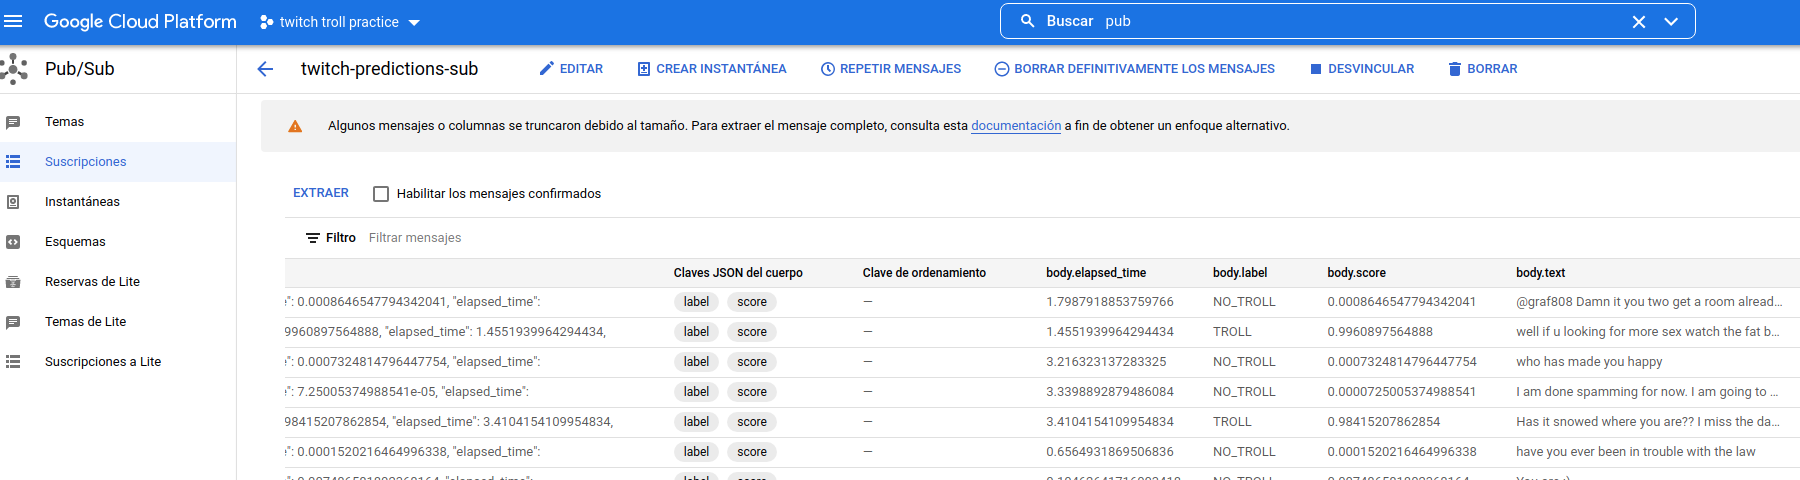